Dataset loaded with shape: (60, 13)
Training data shape: (41, 7, 12)
Testing data shape: (12, 7, 12)


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,825 (335.25 KB)

 Trainable params: 85,825 (335.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 934ms/step - loss: 0.1525 - val_loss: 0.0694 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0799 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0646 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0395 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0574 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0441 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0412 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0324 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0325 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━

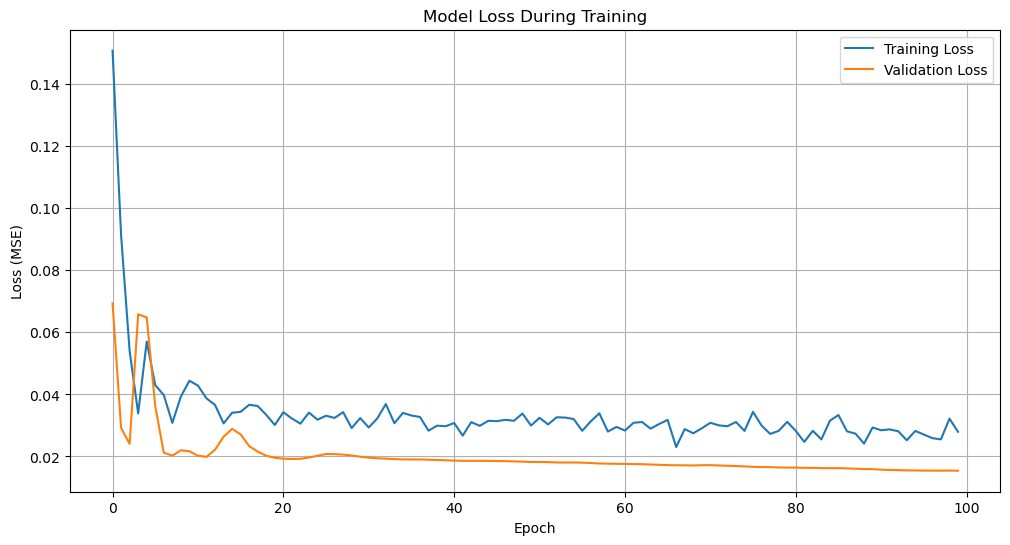

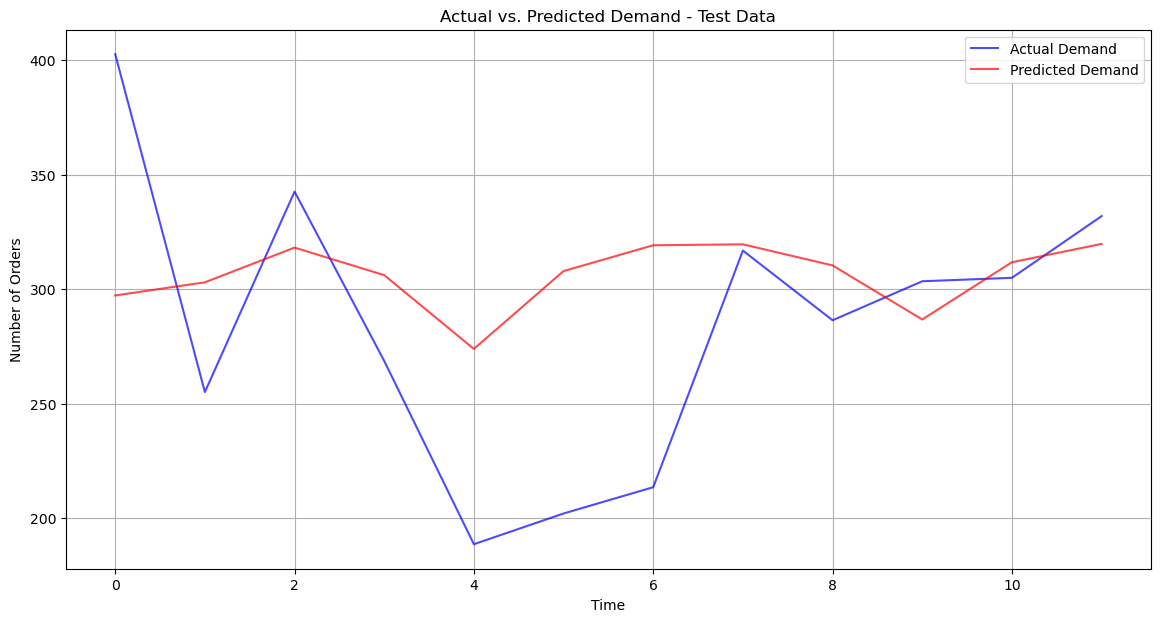

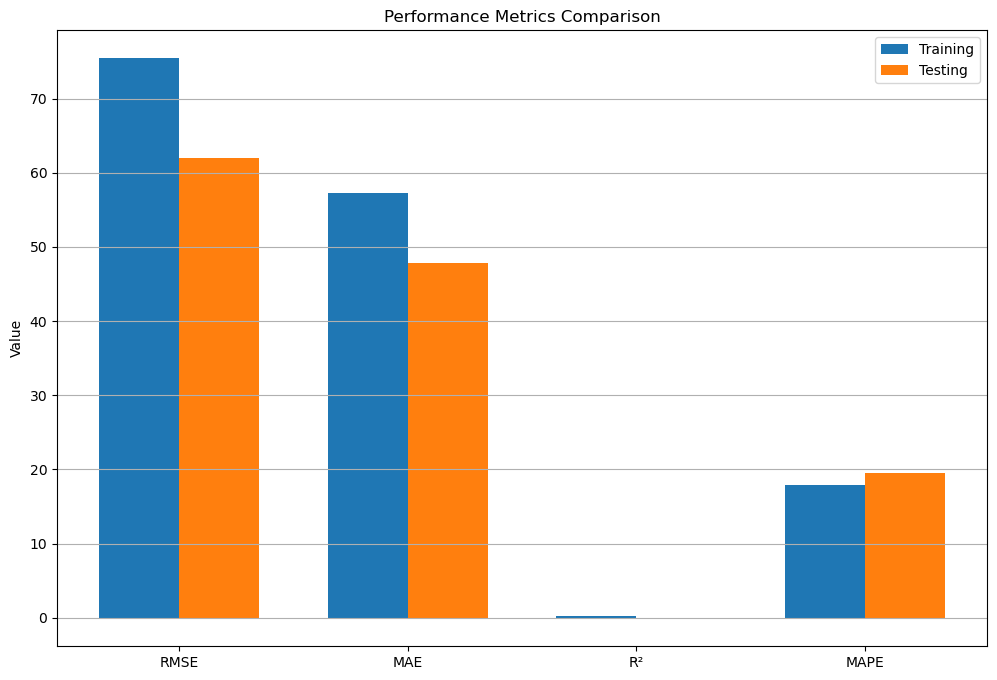

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from urllib.request import urlretrieve

# Load dataset
def load_demand_dataset():
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
    local_filename = "Daily_Demand_Forecasting_Orders.csv"
    
    if not os.path.exists(local_filename):
        print("Downloading dataset...")
        urlretrieve(dataset_url, local_filename)
    
    df = pd.read_csv(local_filename, delimiter=';', decimal=',')
    print(f"Dataset loaded with shape: {df.shape}")
    return df

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

df = load_demand_dataset()

df = df.iloc[:, 1:]  # Drop the first column if it's unnecessary

y = df.iloc[:, -1].values.reshape(-1, 1)  # Target variable

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df)
y_scaled = scaler_y.fit_transform(y)

sequence_length = 7  # One week lookback
train_size = int(len(X_scaled) * 0.8)

X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]

X_train, y_train = create_sequences(X_train_data, y_train_data, sequence_length)
X_test, y_test = create_sequences(X_test_data, y_test_data, sequence_length)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Build LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features), recurrent_dropout=0.1),
        LSTM(64, return_sequences=True, recurrent_dropout=0.1),
        LSTM(64, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model(sequence_length, X_train.shape[2])
print(model.summary())

# Visualize Model
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predictions = scaler_y.inverse_transform(test_predictions)
y_test_inv = scaler_y.inverse_transform(y_test)

# Calculate metrics
def calculate_metrics(actual, predicted):
    return {
        'RMSE': math.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R²': r2_score(actual, predicted),
        'MAPE': np.mean(np.abs((actual - predicted) / (actual + 1e-5))) * 100
    }

train_metrics = calculate_metrics(y_train_inv, train_predictions)
test_metrics = calculate_metrics(y_test_inv, test_predictions)
print("Train Metrics:", train_metrics)
print("Test Metrics:", test_metrics)

# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Plot Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted Demand', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Demand - Test Data')
plt.ylabel('Number of Orders')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions.png')
plt.show()

# Performance Metrics Comparison
metrics_names = list(train_metrics.keys())
train_values = [train_metrics[m] for m in metrics_names]
test_values = [test_metrics[m] for m in metrics_names]
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training')
plt.bar(x + width/2, test_values, width, label='Testing')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.legend()
plt.grid(True, axis='y')
plt.savefig('performance_metrics.png')
plt.show()
